# Kaggle Competition : Home Credit Default Risk 

### Using With Dimension Reduction technique

> Predict how capable each applicant is of repaying a loan.

References:<br>
[Data Sources](https://www.kaggle.com/c/home-credit-default-risk/data) <br>
[Start Here: A Gentle Introduction](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)<br>

task:

> 1. Check dataset

> 2. Data Processing

> 3. Dimension Reduction (PCA)  

> 4. Fit different models and make prediction

            a. Logistic Regression classifier
            b. Random Forest classifier
            c. XGBoost classifier

> 5. Predict the data for kaggle submission

#### kaggle submission result 

![submission result]()

# 1. Check dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
df_test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

In [3]:
df_train.shape

(307511, 122)

In [4]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_test.shape

(48744, 121)

#### inbalanced data

91% of data is 0 (loans that were repaid on time), 8% of data is 1 (loans that were not repaid on time). 

In [6]:
df_train['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

# 2. Data Processing

task:

> a. Outlinear

> b. Missing value

> c. Transform categorical data

> d. Scaling

#### a. deal with Outlinear

We find anomalies when **df_train['DAYS_EMPLOYED'] == 365243**. <br><br>
Let's fill in the anomalous values with **np.nan** and create a new boolean column **'DAYS_EMPLOYED_ANOM'** indicating whether or not the value was anomalous.

In [7]:
# Create an anomalous flag column
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"] == 365243
df_test['DAYS_EMPLOYED_ANOM'] = df_test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
df_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

#### b. Fill in missing value

In [8]:
col_missing_train = list(df_train.columns[df_train.isnull().any()])
col_missing_test = list(df_test.columns[df_test.isnull().any()])

Function from: [Impute categorical missing values in scikit-learn](https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn)

In [9]:
from sklearn.base import TransformerMixin

In [10]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [11]:
imp = DataFrameImputer()
imp.fit(df_train)

df_train = imp.transform(df_train)
df_test = imp.transform(df_test)

In [12]:
# No missing value after imputataion. 

df_test[col_missing_test].isnull().sum(axis = 0)/df_test.shape[0]

AMT_ANNUITY                   0.0
NAME_TYPE_SUITE               0.0
DAYS_EMPLOYED                 0.0
OWN_CAR_AGE                   0.0
OCCUPATION_TYPE               0.0
                             ... 
AMT_REQ_CREDIT_BUREAU_DAY     0.0
AMT_REQ_CREDIT_BUREAU_WEEK    0.0
AMT_REQ_CREDIT_BUREAU_MON     0.0
AMT_REQ_CREDIT_BUREAU_QRT     0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
Length: 65, dtype: float64

#### b. transform categorical data

* Label encoding  →  columns with 2 unique categories.  <br>
* One-hot encoding  →  columns variable with more than 2 unique categories.

In [13]:
#  columns with 2 unique categories
columns_ob_two = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE', 'DAYS_EMPLOYED_ANOM']

Label encoding of 2 unique categorical variables

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in columns_ob_two:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

One-hot encoding of more than two unique categorical variable.

In [15]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

To remove the columns in the training data that are not in the testing data, we need to align the dataframes. 

In [16]:
y_train = df_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 239)


# 3. Dimension Reduction (PCA)

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt

In [22]:
# define training and testing data
X_train = df_train.copy()
X_test = df_test.copy()

In [23]:
# before using PCA, we scale the data by MinMaxScaler

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# applying PCA

pca = PCA() 
pca.fit(X_train_scaled) 

X_train_scaled_pca = pca.transform(X_train_scaled) 
X_train_scaled_pca = pca.transform(X_test_scaled) 

In [21]:
print("shape: {}".format(str(X_train_scaled_pca.shape))) 

shape: (48744, 239)


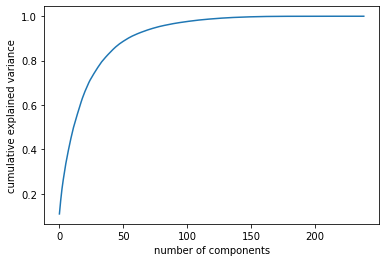

In [22]:
# The PCA class contains explained_variance_ratio_ which returns the variance caused by each of the principal components. 

explained_variance = pca.explained_variance_ratio_

plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

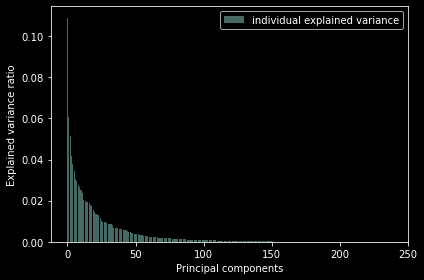

In [23]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

# 4. Fit different Models

Task:

> a. Logistic Regression classifier

> b. Random Forest classifier

> c. XGBoost classifier

#### a. Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [25]:
params_log  = { 'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'logistic__penalty': ['l1', 'l2']}

model = Pipeline([
        ('pca', PCA(n_components = 50)),
        ('logistic', LogisticRegression(max_iter=10000))
    ])

gs_log = GridSearchCV(model, params_log, cv=4, n_jobs=-1, verbose=1)
gs_log.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 14 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  2.9min finished


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pca', PCA(n_components=50)),
                                       ('logistic',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'logistic__penalty': ['l1', 'l2']},
             verbose=1)

In [26]:
# summarize
print('Mean Accuracy: %.3f' % gs_log.best_score_)
print('Config: %s' % gs_log.best_params_)

Mean Accuracy: 0.919
Config: {'logistic__C': 0.001, 'logistic__penalty': 'l2'}


In [ ]:
# final result of logistic:

# Mean Accuracy: 0.919
# Config: {'logistic__C': 0.001, 'logistic__penalty': 'l2'}

#### b. Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
params_rfc  = { 'rfc__max_depth': [10, 25, 50, 75, 100],
                'rfc__n_estimators': [50, 100, 200]}

rfc = RandomForestClassifier(min_samples_split = 10, min_samples_leaf = 4, max_features = 'sqrt')

model_rfc = Pipeline([
        ('pca', PCA(n_components = 50)),
        ('rfc', rfc)
    ])

gs_rfc = GridSearchCV(model_rfc, params_rfc, cv=4, n_jobs=-1, verbose=1)
gs_rfc.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 84.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 129.6min finished


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pca', PCA(n_components=50)),
                                       ('rfc',
                                        RandomForestClassifier(max_features='sqrt',
                                                               min_samples_leaf=4,
                                                               min_samples_split=10))]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': [10, 25, 50, 75, 100],
                         'rfc__n_estimators': [50, 100, 200]},
             verbose=1)

In [29]:
# summarize
print('Mean Accuracy: %.3f' % gs_rfc.best_score_)
print('Config: %s' % gs_rfc.best_params_)

Mean Accuracy: 0.919
Config: {'rfc__max_depth': 100, 'rfc__n_estimators': 100}


In [ ]:
# final result of rfc:

# Mean Accuracy: 0.919
# Config: {'rfc__max_depth': 100, 'rfc__n_estimators': 100}

#### c. XGBoost classifier

[API document](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [20]:
from xgboost.sklearn import XGBClassifier

In [ ]:
params_xgb  = { 'xgb__learning_rate': [0.05, 0.1, 0.5, 1.0],
                'xgb__n_estimators': [100, 250, 500]}

xgb = XGBClassifier()

model_xgb = Pipeline([
        ('pca', PCA(n_components = 50)),
        ('xgb', xgb)
    ])

gs_xgb = GridSearchCV(model_xgb, params_xgb, cv=4, n_jobs=-1, verbose=1)
gs_xgb.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  6.2min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.2min finished


In [32]:
# summarize
print('Mean Accuracy: %.3f' % gs_xgb.best_score_)
print('Config: %s' % gs_xgb.best_params_)

Mean Accuracy: 0.919
Config: {'xgb__learning_rate': 0.05, 'xgb__n_estimators': 100}


In [ ]:
# final result of xgb:

# Mean Accuracy: 0.919
# Config: {'xgb__learning_rate': 0.05, 'xgb__n_estimators': 100}

# 5. predict the data for submission

#### a. Logistic Regression

In [33]:
# Make predictions
# Make sure to select the second column only
result_log = gs_log.predict_proba(X_test_scaled)[:, 1]

In [34]:
submission_log = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': result_log})

In [35]:
submission_log.to_csv('/kaggle/working/HCDR_submission_log_pca.csv', index = False)

#### b. Random Forest

In [36]:
result_rfc = gs_rfc.predict_proba(X_test_scaled)[:, 1]

In [37]:
submission_rfc = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': result_rfc})

In [38]:
submission_rfc.to_csv('/kaggle/working/HCDR_submission_rfc_pca.csv', index = False)

#### c. XGBoost classifier

In [ ]:
result_xgb = gs_xgb.predict_proba(X_test_scaled)[:, 1]

In [ ]:
submission_xgb = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': result_xgb})

In [ ]:
submission_xgb.to_csv('/kaggle/working/HCDR_submission_xgb_pca.csv', index = False)